In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [243]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [244]:
class Net(nn.Module):
    def __init__(self, n_z=2, lr=1e-3, dkl_loss_scale=1.0):
        super().__init__()
        
        self.hidden1 = nn.Linear(28 * 28, 500)
        self.hidden2 = nn.Linear(500, 501)
        
        self.z_mean = nn.Linear(501, n_z)
        self.z_log_sigma_sq = nn.Linear(501, n_z)
        
        self.hidden3 = nn.Linear(n_z, 500)
        self.hidden4 = nn.Linear(500, 501)
        
        self.output = nn.Linear(501, 28 * 28)
        
        self.n_z = n_z
        self.activation = nn.Softplus()
        
        # self._init_weights()
        
        self.optim = optim.Adam(self.parameters(), lr=lr)
        self.dkl_loss_scale = dkl_loss_scale
    
    def _init_weights(self):
        for layer in [
            self.hidden1, self.hidden2, self.hidden3, self.hidden4,
            self.z_mean, self.z_log_sigma_sq, self.output
        ]:
            layer.weight.data = torch.empty(layer.weight.data.shape).normal_(std=0.1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        
        z_mean = self.z_mean(x)
        z_log_sigma_sq = self.z_log_sigma_sq(x)
        
        self._last_dkl_loss = (1 + z_log_sigma_sq - z_mean ** 2 - z_log_sigma_sq.exp()).sum(dim=1) * -0.5
        
        eps = torch.empty(len(x), self.n_z).normal_()
        z = z_log_sigma_sq.exp().sqrt().mul(eps).add(z_mean)
        
        z = self.activation(self.hidden3(z))
        z = self.activation(self.hidden4(z))
        output = torch.sigmoid(self.output(z))
        
        return output
        
    def loss(self, output, target):
        target = (target.view(-1, 28 * 28) + 1.) / 2.0
        
        delta = 1e-10
        cross_entropy_loss = (target * (output + delta).log() + (1 - target) * (delta + 1 - output).log()).sum(dim=1)
        
        self._loss = (self._last_dkl_loss * self.dkl_loss_scale - cross_entropy_loss).mean()
        return self._loss

In [245]:
models = {'default': Net(), 'Scaled1': Net(dkl_loss_scale=35), 'Scaled2': Net(dkl_loss_scale=10)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [246]:
data, _ = next(iter(train_loader))

In [247]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data).backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}, dkl_loss={:.6f}'.format(k, m._loss.item(), m._last_dkl_loss.mean().item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}, dkl_loss={:.6f}'.format(k, m._loss.item(), m._last_dkl_loss.mean().item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [248]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data).item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append((test_loss[k],))
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [249]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 561.479736, dkl_loss=0.106915 Scaled1: 576.098633, dkl_loss=0.425140 Scaled2: 569.712585, dkl_loss=0.720883
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 181.238464, dkl_loss=3.795889 Scaled1: 211.546448, dkl_loss=0.000482 Scaled2: 205.787338, dkl_loss=0.677143
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 158.881866, dkl_loss=4.043220 Scaled1: 199.217148, dkl_loss=0.000307 Scaled2: 188.189178, dkl_loss=0.982540
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 156.185226, dkl_loss=4.603936 Scaled1: 200.080429, dkl_loss=0.000095 Scaled2: 191.093903, dkl_loss=0.865087
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 168.421799, dkl_loss=4.767389 Scaled1: 216.636429, dkl_loss=0.000209 Scaled2: 206.936234, dkl_loss=0.779943
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 160.756699, dkl_loss=4.804361 Scaled1: 204.000229, dkl_loss=0.000151 Scaled2: 193.048157, dkl_loss=0.989508
Test set:
default: loss: 0.0042
Scaled1: loss: 0.0


Train Epoch: 9 [0/50000 (0%)]	Losses default: 138.544220, dkl_loss=5.657998 Scaled1: 194.314545, dkl_loss=0.000255 Scaled2: 186.671371, dkl_loss=1.073779
Train Epoch: 9 [10000/50000 (20%)]	Losses default: 164.134338, dkl_loss=5.578535 Scaled1: 208.776596, dkl_loss=0.000091 Scaled2: 204.944763, dkl_loss=0.961435
Train Epoch: 9 [20000/50000 (40%)]	Losses default: 150.718826, dkl_loss=5.856135 Scaled1: 203.054871, dkl_loss=0.000130 Scaled2: 191.973785, dkl_loss=1.382504
Train Epoch: 9 [30000/50000 (60%)]	Losses default: 149.200546, dkl_loss=6.067516 Scaled1: 207.760834, dkl_loss=0.000237 Scaled2: 194.886703, dkl_loss=1.240862
Train Epoch: 9 [40000/50000 (80%)]	Losses default: 156.365906, dkl_loss=6.485458 Scaled1: 232.678268, dkl_loss=0.000424 Scaled2: 219.832092, dkl_loss=1.539394
Train Epoch: 9 [50000/50000 (100%)]	Losses default: 150.019226, dkl_loss=5.909577 Scaled1: 213.488281, dkl_loss=0.000162 Scaled2: 199.419281, dkl_loss=1.292876
Test set:
default: loss: 0.0038
Scaled1: loss: 0.


Train Epoch: 17 [0/50000 (0%)]	Losses default: 150.152466, dkl_loss=6.454986 Scaled1: 214.935898, dkl_loss=0.000022 Scaled2: 206.136292, dkl_loss=1.590312
Train Epoch: 17 [10000/50000 (20%)]	Losses default: 151.521576, dkl_loss=6.207923 Scaled1: 210.595032, dkl_loss=0.000038 Scaled2: 201.653854, dkl_loss=1.322704
Train Epoch: 17 [20000/50000 (40%)]	Losses default: 158.497025, dkl_loss=5.873934 Scaled1: 213.844299, dkl_loss=0.000058 Scaled2: 205.813751, dkl_loss=1.429363
Train Epoch: 17 [30000/50000 (60%)]	Losses default: 143.670425, dkl_loss=6.231636 Scaled1: 205.423080, dkl_loss=0.000061 Scaled2: 192.120300, dkl_loss=1.662588
Train Epoch: 17 [40000/50000 (80%)]	Losses default: 140.330994, dkl_loss=6.466269 Scaled1: 204.876205, dkl_loss=0.000277 Scaled2: 194.347656, dkl_loss=1.561743
Train Epoch: 17 [50000/50000 (100%)]	Losses default: 146.352829, dkl_loss=6.172383 Scaled1: 207.422943, dkl_loss=0.000033 Scaled2: 192.092422, dkl_loss=1.590383
Test set:
default: loss: 0.0037
Scaled1: lo

Original pictures


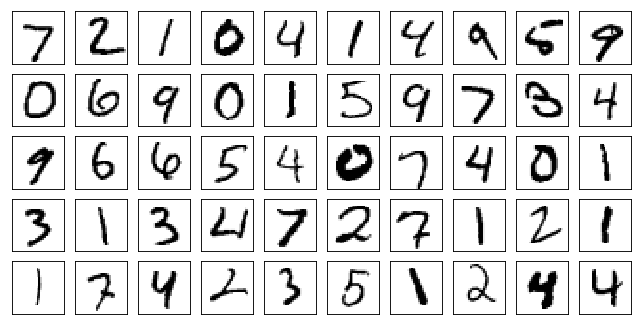

Model default


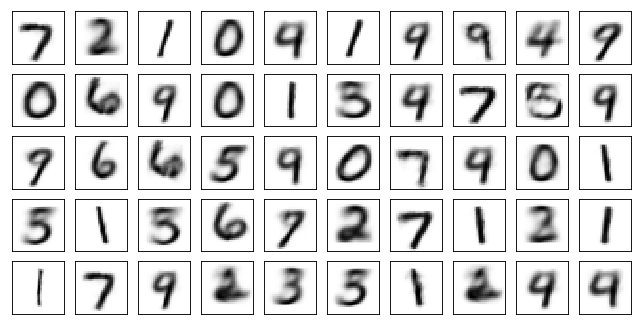

Model Scaled1


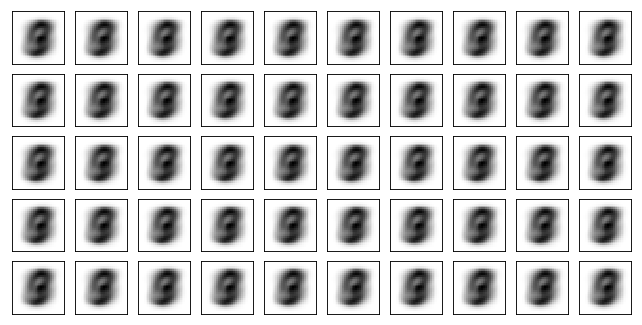

Model Scaled2


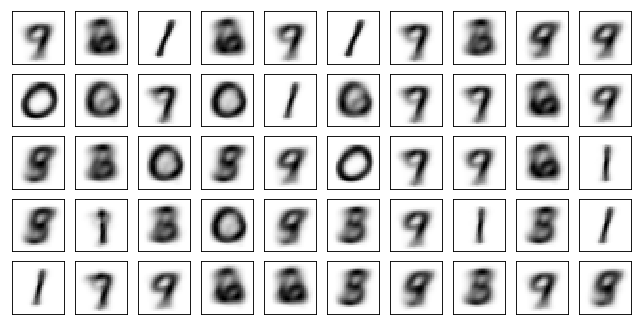

In [250]:
data, _ = next(iter(test_loader))

print('Original pictures')
plot_mnist(data.data.numpy(), (5, 10))

for name, model in models.items():
    output = model(data)
    to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy() 
    
    print('Model {}'.format(name))
    plot_mnist(to_plot, (5, 10))